In [5]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import RandomizedSearchCV
import joblib
import mlflow
import os

# Cargar los datos procesados
X_train = pd.read_csv("../processed_data/X_train.csv")
X_val = pd.read_csv("../processed_data/X_val.csv")
y_train = pd.read_csv("../processed_data/y_train.csv").values.ravel()
y_val = pd.read_csv("../processed_data/y_val.csv").values.ravel()

# Crear carpeta para modelos si no existe
os.makedirs("models", exist_ok=True)

# Inicializar MLflow
mlflow.set_experiment("Tempering-Steel-Regression")

# Lista de modelos a evaluar
models = {
    "LinearRegression": LinearRegression(),
    "Ridge": Ridge(alpha=1.0),
    "Lasso": Lasso(alpha=0.1),
}

results = []

for name, model in models.items():
    with mlflow.start_run(run_name=name):
        model.fit(X_train, y_train)
        y_pred = model.predict(X_val)

        mse = mean_squared_error(y_val, y_pred)
        mae = mean_absolute_error(y_val, y_pred)

        mlflow.log_param("model", name)
        mlflow.log_metric("mse", mse)
        mlflow.log_metric("mae", mae)

        model_path = f"models/{name}.pkl"
        joblib.dump(model, model_path)
        mlflow.log_artifact(model_path)

        results.append({"model": name, "mse": mse, "mae": mae})
# 🔍 Optimización del modelo RandomForest con RandomizedSearchCV
rf_params = {
    "n_estimators": [50, 100, 200, 300],
    "max_depth": [None, 10, 20, 30, 40],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4]
}

rf_random = RandomizedSearchCV(
    estimator=RandomForestRegressor(random_state=42),
    param_distributions=rf_params,
    n_iter=10,
    cv=3,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    random_state=42
)

with mlflow.start_run(run_name="RandomForest_Optimized"):
    rf_random.fit(X_train, y_train)
    best_rf = rf_random.best_estimator_

    y_pred = best_rf.predict(X_val)
    mse = mean_squared_error(y_val, y_pred)
    mae = mean_absolute_error(y_val, y_pred)

    # Registrar hiperparámetros óptimos
    mlflow.log_param("model", "RandomForest_Optimized")
    for param_name, param_val in rf_random.best_params_.items():
        mlflow.log_param(param_name, param_val)

    mlflow.log_metric("mse", mse)
    mlflow.log_metric("mae", mae)

    model_path = "models/RandomForest_Optimized.pkl"
    joblib.dump(best_rf, model_path)
    mlflow.log_artifact(model_path)

    results.append({"model": "RandomForest_Optimized", "mse": mse, "mae": mae})


# Mostrar resultados
results_df = pd.DataFrame(results)
print("\nResultados de validación:")
print(results_df.sort_values("mse"))



Resultados de validación:
                    model        mse       mae
3  RandomForest_Optimized   3.950897  1.356792
1                   Ridge  16.381257  2.998023
0        LinearRegression  16.389369  3.000187
2                   Lasso  16.810706  3.044399


In [2]:
print(results_df.sort_values("mse"))

                    model        mse       mae
4  RandomForest_Optimized   3.746625  1.329500
3            RandomForest   3.950897  1.356792
1                   Ridge  16.381257  2.998023
0        LinearRegression  16.389369  3.000187
2                   Lasso  16.810706  3.044399


In [6]:
import joblib

best_model = joblib.load("models/RandomForest.pkl")

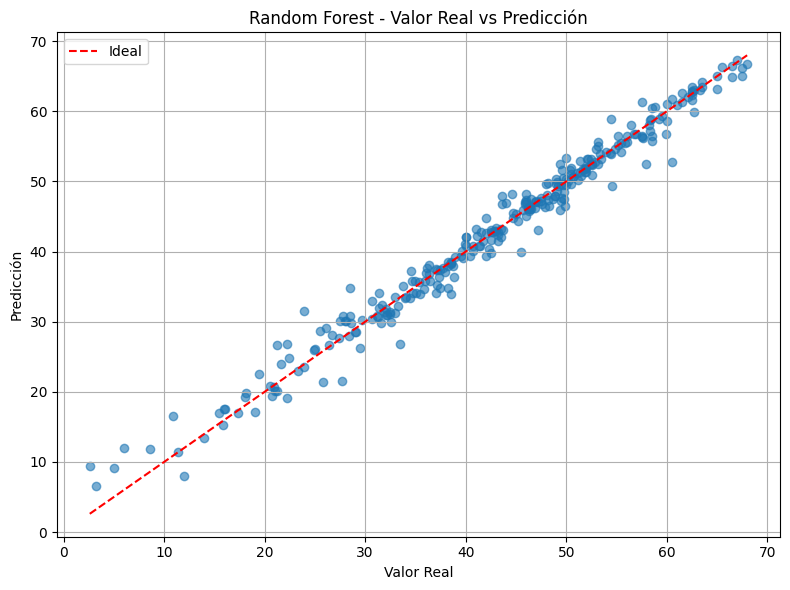

In [7]:
import matplotlib.pyplot as plt

y_pred = best_model.predict(X_val)

plt.figure(figsize=(8, 6))
plt.scatter(y_val, y_pred, alpha=0.6)
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--', label="Ideal")
plt.xlabel("Valor Real")
plt.ylabel("Predicción")
plt.title("Random Forest - Valor Real vs Predicción")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [8]:
pred_df = pd.DataFrame({
    "y_real": y_val,
    "y_pred": y_pred
})
pred_df.to_csv("../results/random_forest_predictions.csv", index=False)